# One-dimensional Schrodinger's Equation

### Run this code to set up the hamiltonian

In [16]:
import numpy as np
import scipy.sparse


def hamiltonian(N, dx, V=None):
    """Returns Hamiltonian using finite differences.

    Args:
        N (int): Number of grid points.
        dx (float): Grid spacing.
        V (array-like): Potential. Must have shape (N,).
            Default is a zero potential everywhere.

    Returns:
        Hamiltonian as a sparse matrix with shape (N, N).
    """
    L = scipy.sparse.diags([1, -2, 1], offsets=[-1, 0, 1], shape=(N, N))
    H = -L / (2 * dx**2)
    if V is not None:
        H += scipy.sparse.spdiags(V, 0, N, N)
    return H.toarray()

In [17]:
import scipy.linalg


def time_evolution_operator(H, dt):
    """Time evolution operator given a Hamiltonian and time step."""
    U = scipy.linalg.expm(-1j * H * dt)
    U[(U.real**2 + U.imag**2) < 1E-10] = 0
    return scipy.sparse.csc_matrix(U)


def simulate(psi, H, dt):
    """Generates wavefunction and time at the next time step."""
    U = time_evolution_operator(H, dt)
    t = 0
    while True:
        yield psi, t * dt
        psi = U @ psi
        t += 1

In [18]:
def probability_density(psi):
    """Position-space probability density."""
    return psi.real**2 + psi.imag**2

In [19]:
def gaussian_wavepacket(x, x0, sigma0, p0):
    """Gaussian wavepacket at x0 +/- sigma0, with average momentum, p0."""
    A = (2 * np.pi * sigma0**2)**(-0.25)
    return A * np.exp(1j*p0*x - ((x - x0)/(2 * sigma0))**2)

### Animation libraries

In [68]:
# Enable interactive plot
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

# define the animation routine
def animate(psi0, V=lambda x: np.zeros_like(x), dt=1.0, xmin=-20, xmax=140, ymin=0, ymax=0.1, nFrames=100, Npts_x=1000):

    fig, ax = plt.subplots(figsize=(8, 4.5))
    x, dx = np.linspace(xmin, xmax, Npts_x, endpoint=False, retstep=True)
    
    Vofx = V(x) # evaluate the potential
    
    line, = ax.plot([])     # A tuple unpacking to unpack the only plot
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("x")
    ax.set_ylabel(r'$|\Psi|^2$')
    
    Vmax = max(Vofx)
    if Vmax > 0:
        Vfactor = ymax/max(Vofx)*0.8
        ax.fill_between(x, Vofx*Vfactor, color='#F68B74', alpha=0.5)
        ax.plot(x, Vofx*Vfactor, 'r-')
        ax.text(xmin + (xmax-xmin)*0.85, ymax*0.8, r'$V(x)$', color="r", fontsize=16)

    H = hamiltonian(Npts_x, dx, Vofx)   # create the hamiltonian from the potential V
    sim = simulate(psi0, H, dt)         # simulate the wavefunction in this potential
    
    def _frame(frame_num):
        y = probability_density(next(sim)[0])
        line.set_data((x, y))
        return line
    
    anim = FuncAnimation(fig, _frame, frames=nFrames, interval=20, repeat=True)
    
    return anim

### Run the code

To start, a particle moving to the right and scattering off an infinitely strong barrier

<IPython.core.display.Javascript object>


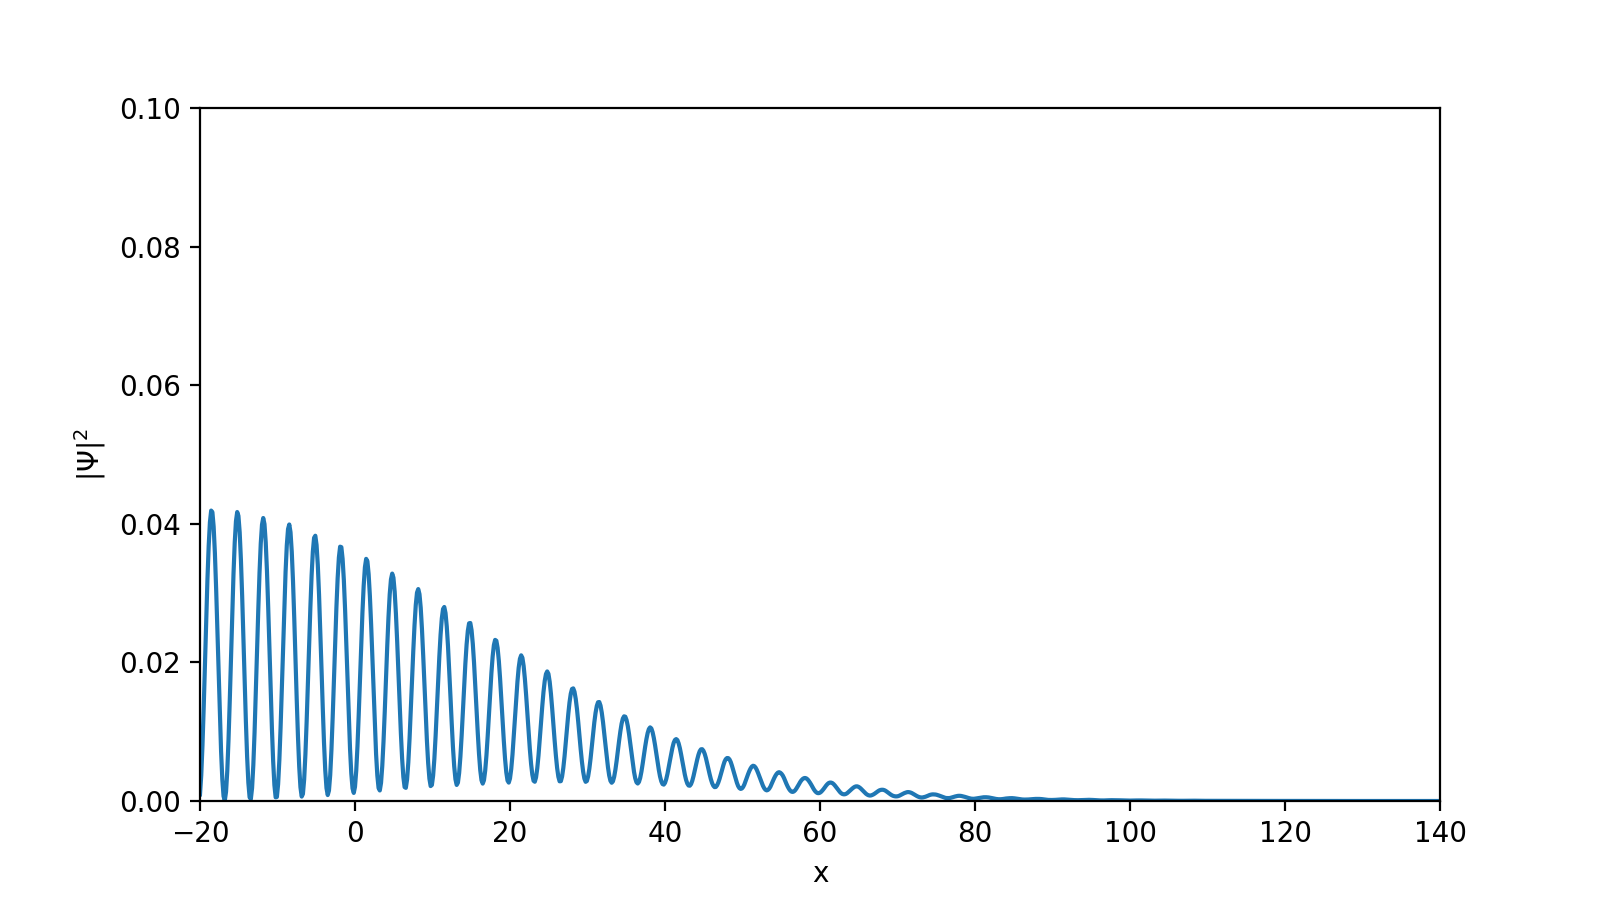

In [29]:
psi0 = gaussian_wavepacket(x, x0=0.0, sigma0=5.0, p0=1.0)
a = animate(psi0, dt=2.0)
a

In [ ]:
Now, a quadratic potential

<IPython.core.display.Javascript object>


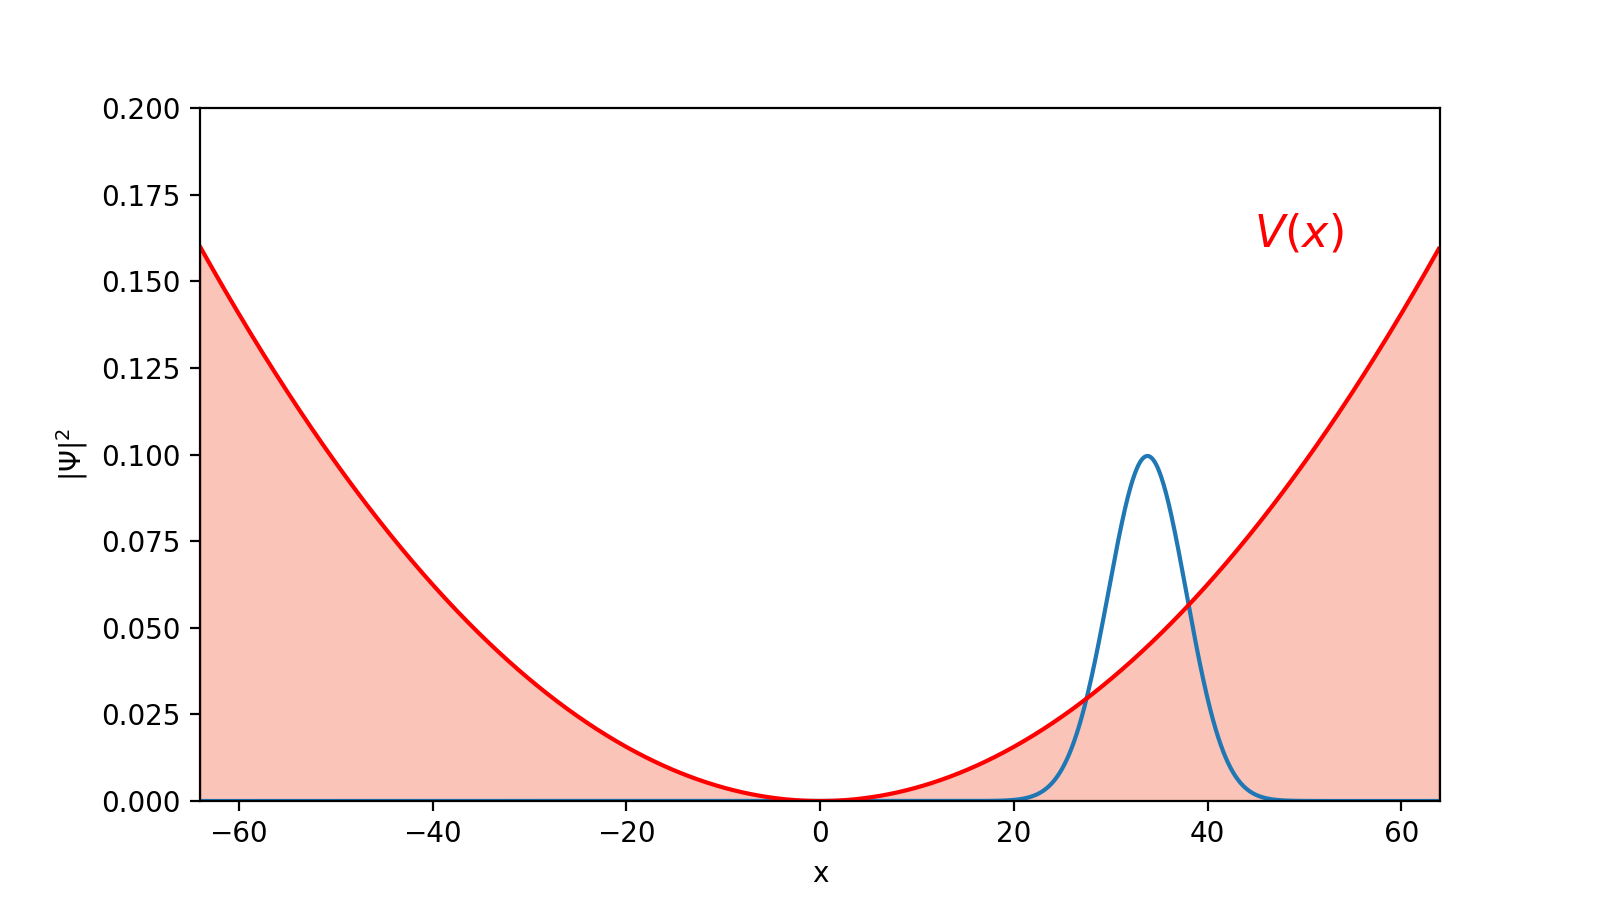

In [69]:
def quadratic(x):
    return (x / 32.0)**2 / 2

psi1 = gaussian_wavepacket(x, x0=-40.0, sigma0=3.0, p0=0.0)
a = animate(psi1, V=quadratic, dt=2.0, xmin=-64, xmax=64, ymax=0.2)
a

References:


http://www.astro.utoronto.ca/~mahajan/notebooks/quantum_tunnelling.html


https://towardsdatascience.com/matplotlib-animations-in-jupyter-notebook-4422e4f0e389